<img src="https://raw.githubusercontent.com/harmonize-tools/socio4health/main/docs/source/_static/image.png" alt="image info" height="100" width="100"/>


# Hands-on with socio4health: socioeconomic and demographic variables on dengue incidence in Colombia


**Run the tutorial via free cloud platforms:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/harmonize-tools/socio4health/HEAD?urlpath=%2Fdoc%2Ftree%2Fdocs%2Fsource%2Fnotebooks%2Fexample_colombia.ipynb) <a target="_blank" href="https://colab.research.google.com/github/harmonize-tools/socio4health/blob/main/docs/source/notebooks/example_colombia.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook provides you with a real world example on how to use **socio4health** to **retrieve**, **harmonize** and **analyze** **socioeconomic and demographic** variables related to **dengue** incidence in Colombia and recreate a data set used in the publication *Exploring Dengue Dynamics: A Multi-Scale Analysis of Spatio-Temporal Trends in Ibagué, Colombia* by Otelo et al., published in *Virus* in 2024 ([DOI](https://doi.org/10.3390/v16060906)). This tutorial assumes you have an **intermediate** or **advanced** understanding of **Python** and data manipulation.

## Setting up the environment

To run this notebook, you need to have the following prerequisites:

- **Python 3.10+**

Additionally, you need to install the `socio4health` and `pandas` package, which can be done using ``pip``:



In [ ]:
!pip install socio4health pandas -q

In [1]:
import sys
import os

custom_path = "../../../src"
if custom_path not in sys.path:
    sys.path.insert(0, custom_path)

## Import Libraries

To perform the data extraction, the `socio4health` library provides the `Extractor` class for data extraction, and the `Harmonizer` class for data harmonization of the retrieved date. `pandas` will be used for data manipulation. Additionally, we will use some utility functions from the `socio4health.utils.harmonizer_utils` module to standardize and translate the dictionary.


In [2]:
import datetime
import pandas as pd
from socio4health import Extractor
from socio4health.harmonizer import Harmonizer
from socio4health.utils import harmonizer_utils

## 1. Extract data from Colombia

To extract data from Colombia, use the `Extractor` class from the `socio4health` library. The `Extractor` class provides methods to retrieve data from various sources, including online databases and local files. As in the publication, extract the Colombian National Population and Housing Census 2018 (**CNPV 2018**) dataset from the Colombian Nacional Administration of Statistics (**DANE**) website. The dataset is available at: https://microdatos.dane.gov.co/index.php/catalog/643/related-materials.

The `Extractor` class requires the following parameters:
- `input_path`: The `URL` or local path to the data source.
- `down_ext`: A list of file extensions to download. This can include `.CSV`, `.csv`, `.zip`, etc.
- `output_path`: The local path where the extracted data will be saved.
- `key_words`: A list of keywords to filter the files to be downloaded. In this case, we are only interested in the file `14045.zip`, which contains the data at the desired level of granularity (census block level or "Manzana").
- `depth`: The depth of the directory structure to traverse when downloading files. A depth of `0` means only the files in the specified directory will be downloaded.



In [3]:
col_online_extractor = Extractor(input_path="https://microdatos.dane.gov.co/index.php/catalog/643/related-materials",
                                 down_ext=['.cpg', '.dbf', '.prj','.sbn', '.sbx', '.shx', '.shp', '.zip'],
                                 output_path="../CNVP2018",
                                 key_words=["14045.zip"],
                                 depth=0)
col_CNPV = col_online_extractor.extract()

2025-09-14 21:07:36,742 - INFO - ----------------------
2025-09-14 21:07:36,743 - INFO - Starting data extraction...
2025-09-14 21:07:36,743 - INFO - Extracting data in online mode...
2025-09-14 21:07:36,744 - INFO - Scraping URL: https://microdatos.dane.gov.co/index.php/catalog/643/related-materials with depth 0
2025-09-14 21:07:40,327 - INFO - Spider completed successfully for URL: https://microdatos.dane.gov.co/index.php/catalog/643/related-materials
2025-09-14 21:07:40,329 - INFO - Downloading files to: ../CNVP2018
2025-09-14 21:08:09,917 - INFO - Processing (depth 0): 14045.zip
2025-09-14 21:08:15,058 - INFO - Extracted: 383d6920_MGN_NivelManzana_Integrado_CNPV_MGN_ANM_MANZANA.cpg
2025-09-14 21:08:36,170 - INFO - Extracted: 383d6920_MGN_NivelManzana_Integrado_CNPV_MGN_ANM_MANZANA.dbf
2025-09-14 21:08:36,173 - INFO - Extracted: 383d6920_MGN_NivelManzana_Integrado_CNPV_MGN_ANM_MANZANA.prj
2025-09-14 21:08:36,177 - INFO - Extracted: 383d6920_MGN_NivelManzana_Integrado_CNPV_MGN_ANM_MA

In [6]:
col_CNPV[0]

,COD_DANE_A,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,CLAS_CCDGO,SETR_CCDGO,SETR_CCNCT,SECR_CCDGO,SECR_CCNCT,ZU_CCDGO,...,TP51_13_ED,TP51_99_ED,CD_LC_CM,NMB_LC_CM,TP_LC_CM,Shape_Leng,Shape_Area,COD_RDTM,geometry,filename
0,0500210000000000010101,05,002,05002,1,000,050021000,00,05002100000,000,...,10.0,1.0,None,None,None,0.002298,2.038760e-07,050021990000000000010101,"POLYGON ((-75.42779 5.79423, -75.4278 5.79422,...",383d6920_MGN_NivelManzana_Integrado_CNPV_MGN_A...
1,0500210000000000010102,05,002,05002,1,000,050021000,00,05002100000,000,...,19.0,4.0,None,None,None,0.003402,5.600867e-07,050021990000000000010102,"POLYGON ((-75.42719 5.79421, -75.42715 5.79415...",383d6920_MGN_NivelManzana_Integrado_CNPV_MGN_A...
2,0500210000000000010103,05,002,05002,1,000,050021000,00,05002100000,000,...,6.0,1.0,None,None,None,0.002622,4.293780e-07,050021990000000000010103,"POLYGON ((-75.42804 5.79294, -75.42807 5.79291...",383d6920_MGN_NivelManzana_Integrado_CNPV_MGN_A...
3,0500210000000000010104,05,002,05002,1,000,050021000,00,05002100000,000,...,11.0,2.0,None,None,None,0.002673,4.493171e-07,050021990000000000010104,"POLYGON ((-75.42853 5.79348, -75.4286 5.79342,...",383d6920_MGN_NivelManzana_Integrado_CNPV_MGN_A...
4,0500210000000000010105,05,002,05002,1,000,050021000,00,05002100000,000,...,0.0,0.0,None,None,None,0.001338,8.776894e-08,050021990000000000010105,"POLYGON ((-75.4291 5.79393, -75.4291 5.79393, ...",383d6920_MGN_NivelManzana_Integrado_CNPV_MGN_A...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504991,9977320030102700010102,99,773,99773,2,003,997732003,01,99773200301,027,...,0.0,0.0,None,None,None,0.002270,2.451366e-07,997732990030102700010102,"POLYGON ((-69.85155 4.33427, -69.85149 4.33427...",383d6920_MGN_NivelManzana_Integrado_CNPV_MGN_A...
504992,9977320030102700010103,99,773,99773,2,003,997732003,01,99773200301,027,...,0.0,0.0,None,None,None,0.002919,5.196303e-07,997732990030102700010103,"POLYGON ((-69.85227 4.33365, -69.85257 4.3337,...",383d6920_MGN_NivelManzana_Integrado_CNPV_MGN_A...
504993,9977320030102700010104,99,773,99773,2,003,997732003,01,99773200301,027,...,0.0,0.0,None,None,None,0.002938,3.280837e-07,997732990030102700010104,"POLYGON ((-69.85276 4.33338, -69.85274 4.3336,...",383d6920_MGN_NivelManzana_Integrado_CNPV_MGN_A...
504994,9977320030102700010105,99,773,99773,2,003,997732003,01,99773200301,027,...,0.0,0.0,None,None,None,0.002514,3.375903e-07,997732990030102700010105,"POLYGON ((-69.85313 4.33348, -69.85311 4.33368...",383d6920_MGN_NivelManzana_Integrado_CNPV_MGN_A...


# 2. Load and standardize the dictionary
To harmonize the data, provide a dictionary that describes the variables in the dataset. The CNPV 2018 dictionary is available at [here](https://microdatos.dane.gov.co/index.php/catalog/643/download/14045). Create a raw dictionary, which we will then standardize and translate to English. Follow the steps in the tutorial ["How to Create a Raw Dictionary for Data Harmonization"](https://harmonize-tools.github.io/socio4health/dictionary.html) to create a raw dictionary in Excel format.



In [4]:
raw_dic = pd.read_excel("../../../../Socio4HealthData/Dictionaries/Colombia/DiccionarioManzanaCrudo.xlsx")
raw_dic

,variable_name,type,size,question,description,value
0,COD_DANE_A,Text,22.0,"Código de manzana concatenado (departamento, m...",NaN,NaN
1,DPTO_CCDGO,Text,2.0,Código del departamento,NaN,NaN
2,MPIO_CCDGO,Text,3.0,Código del municipio,NaN,NaN
3,MPIO_CDPMP,Text,5.0,Código concatenado que identifica al municipio,NaN,NaN
4,CLAS_CCDGO,Text,1.0,"Código de la clase 1 cabecera municipal, 2 cen...",NaN,NaN
...,...,...,...,...,...,...
101,TP51_13_ED,Double,NaN,Conteo de personas donde el nivel educativo de...,Ninguno,NaN
102,TP51_99_ED,Double,NaN,Conteo de personas donde el nivel educativo de...,Sin información,NaN
103,CD_LC_CM,Text,10.0,Código de la localidad o comuna,NaN,NaN
104,NMB_LC_CM,Text,50.0,Nombre de la localidad o comuna,NaN,NaN


Standardize the dictionary using the `standardize_dict` function from the `harmonizer_utils` module. Then, translate it to English using the `translate_column` function from the same module (Note: This function depends on your internet connection and Google's deep_translator extension, so it may takes a few minutes). Finally, classify the variables into categories using a pre-trained **BERT model**.

In [5]:
dic = harmonizer_utils.standardize_dict(raw_dic)
dic = harmonizer_utils.translate_column(dic, "question", language="en")
dic = harmonizer_utils.translate_column(dic, "description", language="en")
dic = harmonizer_utils.translate_column(dic, "possible_answers", language="en")
dic = harmonizer_utils.classify_rows(dic, "question_en", "description_en", "possible_answers_en",
                                        new_column_name="category",
                                        MODEL_PATH="../../../../Socio4HealthData/input/bert_finetuned_classifier")

c:\Users\Juan\OneDrive - Universidad de los andes\Uniandes\2025\Harmonize\socio4health\docs\source\notebooks\../../../src\socio4health\utils\harmonizer_utils.py:99: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_process_group, include_groups=True)\


question translated
description translated
possible_answers translated


Device set to use cpu


# 3. Harmonize the data

Use the Harmonizer class from the **socio4health** library to harmonize the data. This class provides methods for harmonizing data based on a provided dictionary. First, set the similarity threshold to `0.9`, meaning that only variables with a similarity score of `0.9` or higher will be considered for harmonization. Next, set the `nan_threshold` to `1`, meaning that only variables with no missing values will be considered for harmonization.

The available columns in the dataset can be checked using the `get_available_columns` method. This method takes a list of DataFrames as input and returns a list of column names that are present in the DataFrames.

In [6]:
har = Harmonizer()
har.similarity_threshold = 0.9
har.nan_threshold = 1
available_columns = har.get_available_columns(col_CNPV)
available_columns

['AG_CCDGO',
 'AREA',
 'CD_LC_CM',
 'CLAS_CCDGO',
 'COD_DANE_A',
 'COD_RDTM',
 'CTNENCUEST',
 'DATO_ANM',
 'DENSIDAD',
 'DPTO_CCDGO',
 'LATITUD',
 'LONGITUD',
 'MANZ_CCDGO',
 'MPIO_CCDGO',
 'MPIO_CDPMP',
 'NMB_LC_CM',
 'PERSONAS_L',
 'PERSONAS_S',
 'SECR_CCDGO',
 'SECR_CCNCT',
 'SECU_CCDGO',
 'SECU_CCNCT',
 'SETR_CCDGO',
 'SETR_CCNCT',
 'SETU_CCDGO',
 'SETU_CCNCT',
 'Shape_Area',
 'Shape_Leng',
 'TP14_1_TIP',
 'TP14_2_TIP',
 'TP14_3_TIP',
 'TP14_4_TIP',
 'TP14_5_TIP',
 'TP14_6_TIP',
 'TP15_1_OCU',
 'TP15_2_OCU',
 'TP15_3_OCU',
 'TP15_4_OCU',
 'TP16_HOG',
 'TP19_ACU_1',
 'TP19_ACU_2',
 'TP19_ALC_1',
 'TP19_ALC_2',
 'TP19_EE_1',
 'TP19_EE_2',
 'TP19_EE_E1',
 'TP19_EE_E2',
 'TP19_EE_E3',
 'TP19_EE_E4',
 'TP19_EE_E5',
 'TP19_EE_E6',
 'TP19_EE_E9',
 'TP19_GAS_1',
 'TP19_GAS_2',
 'TP19_GAS_9',
 'TP19_INTE1',
 'TP19_INTE2',
 'TP19_INTE9',
 'TP19_RECB1',
 'TP19_RECB2',
 'TP27_PERSO',
 'TP32_1_SEX',
 'TP32_2_SEX',
 'TP34_1_EDA',
 'TP34_2_EDA',
 'TP34_3_EDA',
 'TP34_4_EDA',
 'TP34_5_EDA',
 'TP34

Configure the dictionary, categories, additional columns, key column, and key values to prepare for the harmonization process. Set the `dict_df` parameter to the standardized and translated dictionary. Set the `categories` parameter to "Housing" to ensure that only housing-related variables are considered for harmonization. Set the `extra_cols` and `key_col`parameter to `MPIO_CDPMP`, which stands for the municipality code. This allows for **filtering the data** to include only records from a specific municipality. In this case, we are interested in the municipality with the code "73001", which corresponds to Ibague. Finally, use the `data_selector` method to **filter the data based on the specified key column and key values**. This method returns a list of DataFrames that match the filtering criteria.

In [14]:
col_CNPV[0].shape

(504996, 111)

In [9]:
har.dict_df = dic
har.categories = ["Housing"]
har.extra_cols = ['MPIO_CDPMP', 'GEOMETRY']
har.key_col = 'MPIO_CDPMP'
har.key_val = ['73001']
filtered_ddfs = har.data_selector(col_CNPV)

The method `compare_with_dict` can be used to compare the available columns in the dataset with the variables in the dictionary. This method helps to identify which variables from the dictionary are present in the dataset and can be harmonized.

Finally, display the filtered DataFrames to see the harmonized data for the specified municipality. If needed, the harmonized data can be exported to a CSV file using the `to_csv` method.

In [10]:
har.compare_with_dict(col_CNPV)

Matches with dict_df: 106 (95.50%)


,Unmatched ddfs variable,Unmatched dict_df variables
0,COD_RDTM,None
1,FILENAME,None
2,GEOMETRY,None
3,SHAPE_AREA,None
4,SHAPE_LENG,None


Finally, display the filtered DataFrames to see the harmonized data for the specified municipality. If needed, the harmonized data can be exported to a CSV file using the `to_csv` method Or graph the results as shown below:

In [11]:
filtered_ddfs[0]

,MPIO_CDPMP,TP9_4_USO,TP9_2_USO,TP9_3_USO,TP9_1_USO,TP9_2_9_MI,TP9_3_4_NO,TP9_3_7_NO,TP9_3_3_NO,TP9_3_99_N,...,TP19_INTE2,TP19_RECB2,TP14_2_TIP,TP14_1_TIP,TP14_6_TIP,TP14_3_TIP,TP14_4_TIP,TP14_5_TIP,TP15_3_OCU,GEOMETRY
422086,73001,0.0,1.0,1.0,48.0,0.0,0.0,0.0,0.0,0.0,...,38.0,0.0,10.0,22.0,1.0,16.0,0.0,0.0,1.0,"POLYGON ((-75.25204 4.45339, -75.25203 4.45339..."
422087,73001,0.0,0.0,2.0,67.0,0.0,0.0,0.0,0.0,0.0,...,8.0,1.0,57.0,10.0,0.0,0.0,0.0,0.0,2.0,"POLYGON ((-75.24798 4.44987, -75.24797 4.44985..."
422088,73001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-75.24873 4.44883, -75.24877 4.44879..."
422089,73001,0.0,2.0,3.0,110.0,0.0,0.0,0.0,1.0,0.0,...,63.0,3.0,81.0,20.0,0.0,11.0,0.0,0.0,1.0,"POLYGON ((-75.24897 4.44924, -75.24893 4.44919..."
422090,73001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-75.25099 4.45195, -75.25111 4.45187..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427978,73001,0.0,1.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,5.0,4.0,1.0,9.0,0.0,0.0,0.0,0.0,2.0,"POLYGON ((-75.19101 4.35893, -75.191 4.35893, ..."
427979,73001,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((-75.18923 4.35806, -75.18929 4.35799..."
427980,73001,0.0,1.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,8.0,4.0,0.0,10.0,0.0,0.0,0.0,0.0,2.0,"POLYGON ((-75.19102 4.35539, -75.19116 4.35513..."
427981,73001,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,...,7.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((-75.19008 4.35431, -75.18991 4.35423..."


c:\Users\Juan\anaconda3\envs\social4health\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Juan\anaconda3\envs\social4health\Lib\site-packages\matplotlib\colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
c:\Users\Juan\anaconda3\envs\social4health\Lib\site-packages\matplotlib\colors.py:2295: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


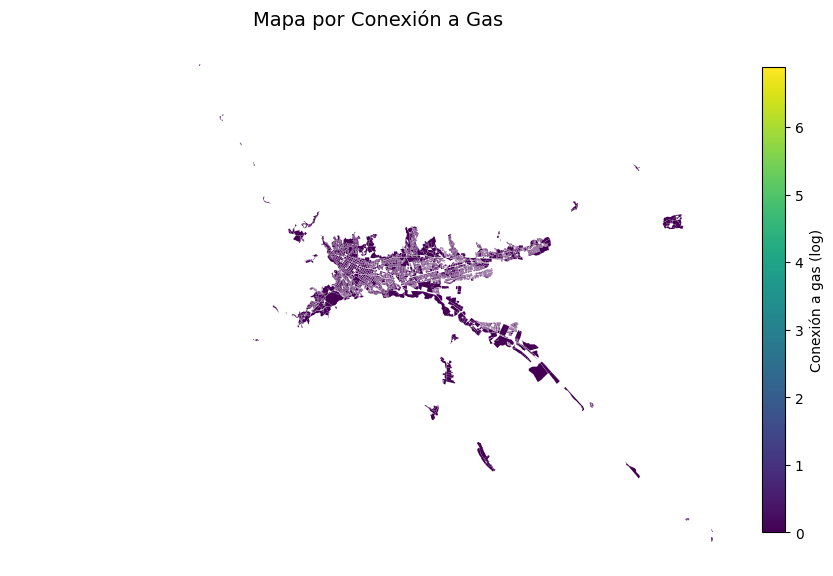

In [22]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

df = filtered_ddfs[0]

# Crear GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='GEOMETRY', crs="EPSG:4326")
gdf['TP19_GAS_1_Log'] = np.log(gdf['TP19_GAS_1'])

# Graficar
fig, ax = plt.subplots(figsize=(10, 8))
# plot sin leyenda automática
gdf.plot(column='TP19_GAS_1_Log', cmap='viridis', ax=ax)

# Crear barra de color manualmente más pequeña
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array(gdf['TP19_GAS_1_Log'])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)  # fraction controla el grosor, pad la distancia
cbar.set_label("Conexión a gas (log)")

ax.set_title("Mapa por Conexión a Gas", fontsize=14)
ax.set_axis_off()
plt.show()